In [2]:
%matplotlib inline

import random, math, pickle
from collections import Counter

import numpy as np
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, reciprocal_rank, recall_at_k
from lightfm.cross_validation import random_train_test_split

C:\Users\mm4me\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [3]:
# load in data
r = pd.read_csv("review_r_and_f", index_col="review_id")
print(r.shape)

b = pd.read_csv("business_r_and_f_8.4.csv", index_col="business_id")
#b = pd.read_csv("business_r_and_f.csv", index_col="business_id")
print(b.shape)

u = pd.read_csv("user_r_and_f", index_col="user_id")
print(u.shape)

(1953249, 8)
(18504, 202)
(654161, 22)


### Subset to Las Vegas and Phoenix

In [4]:
b = b[b.city.isin(['Las Vegas', 'Phoenix'])]
print(b.shape)

r = r[r.business_id.isin(b.index)]
print(r.shape)

u = u[u.index.isin(r.user_id)]
print(u.shape)

(8329, 202)
(1291335, 8)
(482806, 22)


In [5]:
print(f"There are average of {r.shape[0]/u.shape[0]} reviews left per user.")
print(f"There are average of {r.shape[0]/b.shape[0]} reviews per business.")

There are average of 2.6746457169132114 reviews left per user.
There are average of 155.04082122703807 reviews per business.


### Las Vegas & Phoenix Intersection

In [6]:
r['city'] = r['business_id'].map(b['city'])

# users in Las Vegas
u_lv = Counter([u for u in r['user_id'][r['city'] == 'Las Vegas']])

# users in Phoenix
u_ph = Counter([u for u in r['user_id'][r['city'] == 'Phoenix']])

# get intersection of users in Las Vegas and Phoenix
u_lv_ph = list(set([u for u in u_lv.keys()]) & set([u for u in u_ph.keys()]))

# subset by users in both cities and businesses that have been rated by those users
r_lv_ph = r[(r['user_id'].isin(u_lv_ph)) & (r['city'].str.contains('Las Vegas|Phoenix'))]
print(r_lv_ph.business_id.nunique(), r_lv_ph.user_id.nunique())

6996 13346


In [7]:
# save the list of intersection users
with open("u_lv_ph.pkl", "wb") as f:
    pickle.dump(u_lv_ph, f)

### Normalize numeric business features

In [8]:
features = [
    'stars',
    'price',
    'review_count',
    '1star_ratio',
    '2star_ratio',
    '3star_ratio',
    '4star_ratio',
    '5star_ratio',
    'word_count',
    'text_friendly',
    'text_reasonable',
    'text_local',
    'text_comfortable',
    'text_easy',
    'text_quick'
]

b[features].describe()

stars        price  review_count  1star_ratio  2star_ratio  \
count  8329.000000  8329.000000   8329.000000  8329.000000  8329.000000   
mean      3.487273     1.556129      3.953350     0.203378     0.091760   
std       0.862876     0.607550      1.495733     0.193899     0.082486   
min       1.000000     1.000000      1.386294     0.000000     0.000000   
25%       3.000000     1.000000      2.772589     0.056604     0.032258   
50%       3.500000     2.000000      3.891820     0.142857     0.078846   
75%       4.000000     2.000000      5.056246     0.304348     0.133333   
max       5.000000     4.000000      8.983314     1.000000     1.000000   

       3star_ratio  4star_ratio  5star_ratio   word_count  text_friendly  \
count  8329.000000  8329.000000  8329.000000  8329.000000    8329.000000   
mean      0.113695     0.198450     0.392600     4.510058       0.110003   
std       0.091428     0.119165     0.240202     0.283240       0.096378   
min       0.000000     0.000000     0.000000     3.120895       0.000000   
25%       0.055172     0.120000     0.204819     4.361682       0.043478   
50%       0.104987     0.200000     0.366906     4.522641       0.096774   
75%       0.157895     0.272727     0.555556     4.673678       0.153846   
max       1.000000     1.000000     1.000000     6.256709       1.000000   

       text_reasonable   text_local  text_comfortable    text_easy  \
count      8329.000000  8329.000000       8329.000000  8329.000000   
mean          0.015680     0.022963          0.006775     0.019298   
std           0.032895     0.055895          0.019948     0.038114   
min           0.000000     0.000000          0.000000     0.000000   
25%           0.000000     0.000000          0.000000     0.000000   
50%           0.000000     0.000000          0.000000     0.007952   
75%           0.021552     0.023857          0.007203     0.024658   
max           1.000000     1.000000          0.500000     0.750000   

        text_quick  
count  8329.000000  
mean      0.043755  
std       0.056268  
min       0.000000  
25%       0.000000  
50%       0.032258  
75%       0.061321  
max       1.000000

In [9]:
# features to normalize

norm_features = [
    "stars",
    "price",
    "review_count",
    "word_count",
    "text_comfortable"
]

for feature in norm_features:
    b[feature] = (b[feature] - min(b[feature])) / (max(b[feature]) - min(b[feature]))

b[features].describe()

stars        price  review_count  1star_ratio  2star_ratio  \
count  8329.000000  8329.000000   8329.000000  8329.000000  8329.000000   
mean      0.621818     0.185376      0.337903     0.203378     0.091760   
std       0.215719     0.202517      0.196884     0.193899     0.082486   
min       0.000000     0.000000      0.000000     0.000000     0.000000   
25%       0.500000     0.000000      0.182479     0.056604     0.032258   
50%       0.625000     0.333333      0.329804     0.142857     0.078846   
75%       0.750000     0.333333      0.483078     0.304348     0.133333   
max       1.000000     1.000000      1.000000     1.000000     1.000000   

       3star_ratio  4star_ratio  5star_ratio   word_count  text_friendly  \
count  8329.000000  8329.000000  8329.000000  8329.000000    8329.000000   
mean      0.113695     0.198450     0.392600     0.442999       0.110003   
std       0.091428     0.119165     0.240202     0.090324       0.096378   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.055172     0.120000     0.204819     0.395683       0.043478   
50%       0.104987     0.200000     0.366906     0.447012       0.096774   
75%       0.157895     0.272727     0.555556     0.495177       0.153846   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

       text_reasonable   text_local  text_comfortable    text_easy  \
count      8329.000000  8329.000000       8329.000000  8329.000000   
mean          0.015680     0.022963          0.013550     0.019298   
std           0.032895     0.055895          0.039896     0.038114   
min           0.000000     0.000000          0.000000     0.000000   
25%           0.000000     0.000000          0.000000     0.000000   
50%           0.000000     0.000000          0.000000     0.007952   
75%           0.021552     0.023857          0.014406     0.024658   
max           1.000000     1.000000          1.000000     0.750000   

        text_quick  
count  8329.000000  
mean      0.043755  
std       0.056268  
min       0.000000  
25%       0.000000  
50%       0.032258  
75%       0.061321  
max       1.000000

In [10]:
b["5star_ratio"] = np.where(b["5star_ratio"] > 1, 1, b["5star_ratio"])

In [11]:
b[features].describe()

stars        price  review_count  1star_ratio  2star_ratio  \
count  8329.000000  8329.000000   8329.000000  8329.000000  8329.000000   
mean      0.621818     0.185376      0.337903     0.203378     0.091760   
std       0.215719     0.202517      0.196884     0.193899     0.082486   
min       0.000000     0.000000      0.000000     0.000000     0.000000   
25%       0.500000     0.000000      0.182479     0.056604     0.032258   
50%       0.625000     0.333333      0.329804     0.142857     0.078846   
75%       0.750000     0.333333      0.483078     0.304348     0.133333   
max       1.000000     1.000000      1.000000     1.000000     1.000000   

       3star_ratio  4star_ratio  5star_ratio   word_count  text_friendly  \
count  8329.000000  8329.000000  8329.000000  8329.000000    8329.000000   
mean      0.113695     0.198450     0.392600     0.442999       0.110003   
std       0.091428     0.119165     0.240202     0.090324       0.096378   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.055172     0.120000     0.204819     0.395683       0.043478   
50%       0.104987     0.200000     0.366906     0.447012       0.096774   
75%       0.157895     0.272727     0.555556     0.495177       0.153846   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

       text_reasonable   text_local  text_comfortable    text_easy  \
count      8329.000000  8329.000000       8329.000000  8329.000000   
mean          0.015680     0.022963          0.013550     0.019298   
std           0.032895     0.055895          0.039896     0.038114   
min           0.000000     0.000000          0.000000     0.000000   
25%           0.000000     0.000000          0.000000     0.000000   
50%           0.000000     0.000000          0.000000     0.007952   
75%           0.021552     0.023857          0.014406     0.024658   
max           1.000000     1.000000          1.000000     0.750000   

        text_quick  
count  8329.000000  
mean      0.043755  
std       0.056268  
min       0.000000  
25%       0.000000  
50%       0.032258  
75%       0.061321  
max       1.000000

### Normalize numeric user features

In [12]:
[col for col in u.columns]

['name',
 'review_count',
 'average_stars',
 'yelping_since',
 'friends',
 'fans',
 'elite',
 'cool',
 'funny',
 'useful',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'friend_count']

In [13]:
u.describe()

review_count  average_stars           fans           cool  \
count  482806.000000  482806.000000  482806.000000  482806.000000   
mean       40.344658       3.770646       3.004024      43.529521   
std       115.424484       0.921839      25.006714    1098.171129   
min         0.000000       1.000000       0.000000       0.000000   
25%         4.000000       3.330000       0.000000       0.000000   
50%        10.000000       3.890000       0.000000       0.000000   
75%        30.000000       4.400000       1.000000       1.000000   
max     11942.000000       5.000000    8665.000000  207329.000000   

               funny         useful  compliment_cool  compliment_cute  \
count  482806.000000  482806.000000    482806.000000    482806.000000   
mean       31.550316      60.402004         7.516889         0.440980   
std       788.353529    1133.182809       132.705583        10.475692   
min         0.000000       0.000000         0.000000         0.000000   
25%         0.000000       0.000000         0.000000         0.000000   
50%         0.000000       1.000000         0.000000         0.000000   
75%         1.000000       6.000000         0.000000         0.000000   
max    167360.000000  201798.000000     21804.000000      2250.000000   

       compliment_funny  compliment_hot  compliment_list  compliment_more  \
count     482806.000000   482806.000000    482806.000000    482806.000000   
mean           7.516889        5.557379         0.180758         0.713545   
std          132.705583      125.116432         6.892572        13.684300   
min            0.000000        0.000000         0.000000         0.000000   
25%            0.000000        0.000000         0.000000         0.000000   
50%            0.000000        0.000000         0.000000         0.000000   
75%            0.000000        0.000000         0.000000         0.000000   
max        21804.000000    33534.000000      2350.000000      3868.000000   

       compliment_note  compliment_photos  compliment_plain  \
count    482806.000000      482806.000000     482806.000000   
mean          3.331259           2.676365          7.187044   
std          95.075694         103.524428        130.632921   
min           0.000000           0.000000          0.000000   
25%           0.000000           0.000000          0.000000   
50%           0.000000           0.000000          0.000000   
75%           0.000000           0.000000          1.000000   
max       57475.000000       37415.000000      20643.000000   

       compliment_profile  compliment_writer   friend_count  
count       482806.000000      482806.000000  482806.000000  
mean             0.496189           2.729521      63.718701  
std             17.899490          48.023027     188.630614  
min              0.000000           0.000000       0.000000  
25%              0.000000           0.000000       0.000000  
50%              0.000000           0.000000       7.000000  
75%              0.000000           0.000000      59.000000  
max           6347.000000        9177.000000   12198.000000

count    482806.000000
mean         40.344658
std         115.424484
min           0.000000
25%           4.000000
50%          10.000000
75%          30.000000
max       11942.000000
Name: review_count, dtype: float64

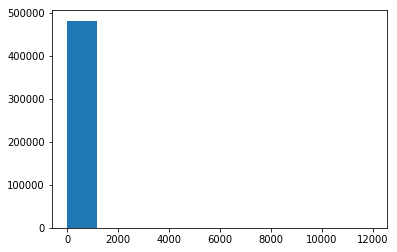

In [14]:
plt.hist(u.review_count)
u.review_count.describe()

count    482806.000000
mean          2.612790
std           1.337002
min           0.000000
25%           1.609438
50%           2.397895
75%           3.433987
max           9.387901
dtype: float64


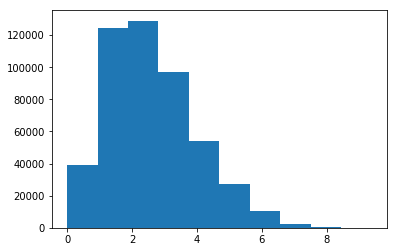

In [15]:
plt.hist(pd.Series([math.log(x+1) for x in u.review_count]))
print(pd.Series([math.log(x+1) for x in u.review_count]).describe())

In [16]:
# log transform review_count
u["review_count"] = [math.log(x+1) for x in u.review_count]

count    482806.000000
mean          2.278546
std           2.065296
min           0.000000
25%           0.000000
50%           2.079442
75%           4.094345
max           9.409109
dtype: float64


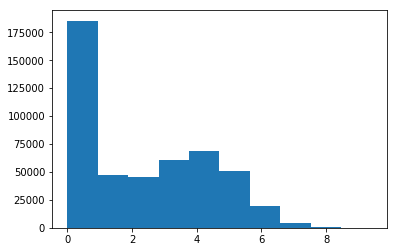

In [17]:
plt.hist(pd.Series([math.log(x+1) for x in u.friend_count]))
print(pd.Series([math.log(x+1) for x in u.friend_count]).describe())

In [18]:
# log transform friend_count
u["friend_count"] = [math.log(x+1) for x in u.friend_count]

count    482806.000000
mean          3.004024
std          25.006714
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        8665.000000
Name: fans, dtype: float64

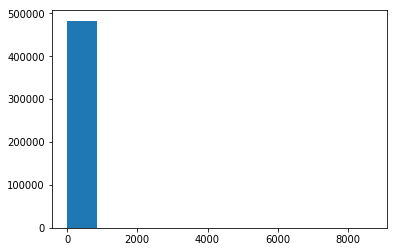

In [19]:
plt.hist(u.fans)
u.fans.describe()

count    482806.000000
mean          0.477546
std           0.891123
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           9.067163
dtype: float64


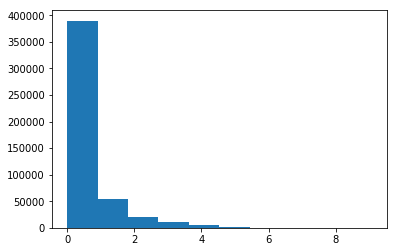

In [20]:
plt.hist(pd.Series([math.log(x+1) for x in u.fans]))
print(pd.Series([math.log(x+1) for x in u.fans]).describe())

In [21]:
for feature in ["fans", "cool", "funny", "useful"]:
    print(f"{feature}: {u[u[feature] == 0].shape[0] / u.shape[0]}")

fans: 0.6742811812612105
cool: 0.6856045699514919
funny: 0.6438051722638078
useful: 0.4557917672936956


In [22]:
norm_features = [
    "review_count",
    "average_stars",
    "friend_count"
]

for feature in norm_features:
    u[feature] = (u[feature] - min(u[feature])) / (max(u[feature]) - min(u[feature]))

u.describe()

review_count  average_stars           fans           cool  \
count  482806.000000  482806.000000  482806.000000  482806.000000   
mean        0.278315       0.692662       3.004024      43.529521   
std         0.142418       0.230460      25.006714    1098.171129   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.171437       0.582500       0.000000       0.000000   
50%         0.255424       0.722500       0.000000       0.000000   
75%         0.365789       0.850000       1.000000       1.000000   
max         1.000000       1.000000    8665.000000  207329.000000   

               funny         useful  compliment_cool  compliment_cute  \
count  482806.000000  482806.000000    482806.000000    482806.000000   
mean       31.550316      60.402004         7.516889         0.440980   
std       788.353529    1133.182809       132.705583        10.475692   
min         0.000000       0.000000         0.000000         0.000000   
25%         0.000000       0.000000         0.000000         0.000000   
50%         0.000000       1.000000         0.000000         0.000000   
75%         1.000000       6.000000         0.000000         0.000000   
max    167360.000000  201798.000000     21804.000000      2250.000000   

       compliment_funny  compliment_hot  compliment_list  compliment_more  \
count     482806.000000   482806.000000    482806.000000    482806.000000   
mean           7.516889        5.557379         0.180758         0.713545   
std          132.705583      125.116432         6.892572        13.684300   
min            0.000000        0.000000         0.000000         0.000000   
25%            0.000000        0.000000         0.000000         0.000000   
50%            0.000000        0.000000         0.000000         0.000000   
75%            0.000000        0.000000         0.000000         0.000000   
max        21804.000000    33534.000000      2350.000000      3868.000000   

       compliment_note  compliment_photos  compliment_plain  \
count    482806.000000      482806.000000     482806.000000   
mean          3.331259           2.676365          7.187044   
std          95.075694         103.524428        130.632921   
min           0.000000           0.000000          0.000000   
25%           0.000000           0.000000          0.000000   
50%           0.000000           0.000000          0.000000   
75%           0.000000           0.000000          1.000000   
max       57475.000000       37415.000000      20643.000000   

       compliment_profile  compliment_writer   friend_count  
count       482806.000000      482806.000000  482806.000000  
mean             0.496189           2.729521       0.242164  
std             17.899490          48.023027       0.219500  
min              0.000000           0.000000       0.000000  
25%              0.000000           0.000000       0.000000  
50%              0.000000           0.000000       0.221003  
75%              0.000000           0.000000       0.435147  
max           6347.000000        9177.000000       1.000000

In [23]:
user_features = [
    "review_count",
    "average_stars",
    "friend_count"
]

u[user_features]

review_count  average_stars  friend_count
user_id                                                          
QPT4Ud4H5sJVr68yXhoWFw      0.073834         0.7500      0.000000
s4FoIXE_LSGviTHBe8dmcg      0.147668         0.5000      0.000000
XoEnrhtJc2pcdlQ09d8Oug      0.171437         0.7500      0.000000
QDQTMYp2NocktWN5fHwfIg      0.073834         1.0000      0.000000
SgYDjNCecPidsRB_su5-tw      0.207279         0.7150      0.000000
NfE1uHFWzzMyXkgBeEuR1A      0.117024         0.0000      0.000000
RiBVI6UgLjfpA4EQ1SWDzA      0.171437         0.7500      0.000000
vLekYe1hK12NJc8PyxRjIg      0.147668         0.5000      0.000000
TpE_T9jESeq-YtqWLyyACQ      0.117024         0.5000      0.000000
DcBtmk6yrU37JVPGPzIHnA      0.147668         1.0000      0.000000
zuiVfy6oJy_N86nw0Wv4Zg      0.190858         0.1675      0.000000
wEUzxhyf7ngRbxS7jIeqsQ      0.255424         0.9500      0.000000
iYXxZBb2trmIozioddpL5g      0.073834         0.2500      0.000000
vfDj6S7vWjjfy9jlkPTfeA      0.147668         0.3325      0.000000
FrLvmygqsfjtHGRx4-poaA      0.307883         0.5300      0.000000
ZNESGFYfd19WknrI63li3A      0.264692         0.5950      0.000000
bRjwncjGoI0ZEdezSKeAYQ      0.234049         0.3750      0.000000
xjmpdJon4hgleU1P5Dj2Pg      0.273219         0.6925      0.000000
-nnXVT844Hm9C4ENKx1N8A      0.117024         0.5000      0.000000
Zz18uz08eyhMAkCJOkFDJQ      0.190858         0.6675      0.000000
E2R4WD4n7V1bGXAtLe8AHQ      0.221502         0.6425      0.000000
pTuhehStwZHOY5kDnUv_Wg      0.273219         0.4800      0.000000
B3xwUPXMlCb7_5IEDlq4Uw      0.234049         0.7225      0.487290
Pc5vc0RuoCa8YU6hD-y3Ow      0.234049         0.8125      0.073668
2hDTGXVbYb03qN1ZPzOnpg      0.190858         0.7000      0.000000
4M6GVM28NHQ7BhM9wG7p0w      0.264692         0.7150      0.000000
GT7EWBgsoWfy6OzrzDEBfg      0.073834         0.0000      0.000000
-caPDnAfiSl_2QxrXX31tQ      0.117024         1.0000      0.000000
6DoRkChoTpUYXOeNSnyJqQ      0.190858         0.9500      0.000000
ctmN5z3jzsGuE475qto3qw      0.117024         0.6250      0.000000
...                              ...            ...           ...
UZFMDw2GLNdTeh_Tt-FS8w      0.147668         0.6675      0.000000
E0-A-nV9uJR4DaSr253Rmw      0.073834         0.0000      0.000000
6ZDEUIhsJa3B-hvPn23ORw      0.147668         1.0000      0.000000
VZ7h6bm8Fc9inHni7_KQLQ      0.117024         0.5000      0.000000
Ozty823J3eZ_hWtiOKc4gg      0.245272         0.6400      0.000000
PNksW5ybtRVVHtJg3G6QKg      0.221502         0.5350      0.000000
1Lh1ZVjBeliwP4E3CDb1UA      0.264692         0.6375      0.000000
ynTB0wce92HFOSMwMnBDBA      0.313642         0.8150      0.000000
4pYFHindebon7OsRtsdgcw      0.342875         0.6050      0.000000
zIRrJJ0NnCx33Yn6F9SMqQ      0.147668         0.8325      0.000000
U2E4aVOe0WYm-aJdT5Syyw      0.147668         0.7500      0.000000
iW1q9DUQzEjOe6yRIKfdhA      0.416709         0.7125      0.000000
1ZtvAwc9i-Fr5mzQfCN_qg      0.301794         0.7950      0.000000
QqDgcJzavTW4GZ3XZar80A      0.147668         1.0000      0.000000
ng8ToWkPbYN2QQd8xVgTRg      0.207279         0.2075      0.000000
4xV4RZ5UQ2T8jhzPFxRCrw      0.307883         0.6375      0.000000
2si9qG7D6ljJEI35UtV6Ng      0.073834         0.0000      0.000000
ErtfeQhtXbV3ccFWqxGyqg      0.245272         0.7750      0.000000
8cFWAHuBQpQIwxat4H5Mcw      0.190858         0.8000      0.000000
yb_dY6mJPhaR2H_pTXhX_Q      0.073834         0.7500      0.000000
wSQVI59NIdFyQ2SDHoy7UA      0.255424         0.9250      0.000000
DgxzftNcQaObBMEa4-7qYA      0.221502         0.3575      0.000000
S_Cl1JxpvP2UErINBKotzg      0.147668         0.5000      0.000000
zXjS_WshFNwu8sEns0tNdw      0.147668         0.7500      0.000000
qGfqAyyPIWoFZ0JC6yClgw      0.459899         0.6100      0.000000
a8mOFGT4ycNL20TCEFkqaA      0.117024         1.0000      0.000000
kwQ3BMAx-_cHmfEFH5qTfw      0.255424         0.6500      0.000000
3Aw_juO9mTtSr1rfqdA1zA      0.313642         0.5125      0.00000

### Review data

In [24]:
# convert stars values into positive or negative
r['sentiment'] = r['stars'].apply(lambda x: 1 if x >3 else -1)

In [83]:
# save the final data
with open("b_final.pkl", "wb") as f:
    pickle.dump(b, f)

with open("r_final.pkl", "wb") as f:
    pickle.dump(r, f)
    
with open("u_final.pkl", "wb") as f:
    pickle.dump(u, f)

In [85]:
# save the busienss features
with open("business_features.pkl", "wb") as f:
    pickle.dump(features, f)

In [3]:
with open("b_final.pkl", "rb") as f:
    b = pickle.load(f)

with open("r_final.pkl", "rb") as f:
    r = pickle.load(f)
    
with open("u_final.pkl", "rb") as f:
    u = pickle.load(f)

### Group features

In [25]:
[col for col in b.columns]

['name',
 'city',
 'las_vegas',
 'stars',
 'price',
 'review_count',
 '1star_ratio',
 '2star_ratio',
 '3star_ratio',
 '4star_ratio',
 '5star_ratio',
 'text',
 'word_count',
 'text_friendly',
 'text_reasonable',
 'text_local',
 'text_comfortable',
 'text_easy',
 'text_quick',
 'cat_Restaurants',
 'cat_Food',
 'cat_Shopping',
 'cat_Active Life',
 'cat_Arts & Entertainment',
 'cat_Nightlife',
 'cat_Hotels & Travel',
 'cat_Tours',
 'state',
 'address',
 'neighborhood',
 'postal_code',
 'latitude',
 'longitude',
 'monday',
 'tuesday',
 'wednesday',
 'thursday',
 'friday',
 'saturday',
 'sunday',
 'Acai Bowls',
 'Afghan',
 'African',
 'American (New)',
 'American (Traditional)',
 'Arcades',
 'Asian Fusion',
 'Bagels',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Bed & Breakfast',
 'Beer',
 'Beer Bar',
 'Bistros',
 'Brasseries',
 'Brazilian',
 'Breakfast & Brunch',
 'Breweries',
 'British',
 'Bubble Tea',
 'Buffets',
 'Burgers',
 'Butcher',
 'Cafes',
 'Cajun/Creole',
 'Canadian (New)',
 'Candy Stores

In [4]:
features = [
 'stars',
 'price',
 'review_count',
 '1star_ratio',
 '2star_ratio',
 '3star_ratio',
 '4star_ratio',
 '5star_ratio',
 'word_count',
 'text_friendly',
 'text_reasonable',
 'text_local',
 'text_comfortable',
 'text_easy',
 'text_quick',
 'cat_Restaurants',
 'cat_Food',
 'cat_Shopping',
 'cat_Active Life',
 'cat_Arts & Entertainment',
 'cat_Nightlife',
 'cat_Hotels & Travel',
 'cat_Tours',
 'Acai Bowls',
 'Afghan',
 'African',
 'American (New)',
 'American (Traditional)',
 'Arcades',
 'Asian Fusion',
 'Bagels',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Bed & Breakfast',
 'Beer',
 'Beer Bar',
 'Bistros',
 'Brasseries',
 'Brazilian',
 'Breakfast & Brunch',
 'Breweries',
 'British',
 'Bubble Tea',
 'Buffets',
 'Burgers',
 'Butcher',
 'Cafes',
 'Cajun/Creole',
 'Canadian (New)',
 'Candy Stores',
 'Cantonese',
 'Caribbean',
 'Casinos',
 'Caterers',
 'Cheesesteaks',
 'Chicken Shop',
 'Chicken Wings',
 'Chinese',
 'Chocolatiers & Shops',
 'Cocktail Bars',
 'Coffee & Tea',
 'Coffee Roasteries',
 'Comfort Food',
 'Convenience Stores',
 'Creperies',
 'Cupcakes',
 'Custom Cakes',
 'Dance Clubs',
 'Delicatessen',
 'Delis',
 'Department Stores',
 'Desserts',
 'Dim Sum',
 'Diners',
 'Dive Bars',
 'Do-It-Yourself Food',
 'Donairs',
 'Donuts',
 'Drugstores',
 'Ethiopian',
 'Ethnic Food',
 'Event Planning & Services',
 'Falafel',
 'Farmers Market',
 'Fashion',
 'Fast Food',
 'Filipino',
 'Fish & Chips',
 'Flowers & Gifts',
 'Food Court',
 'Food Delivery Services',
 'Food Stands',
 'Food Trucks',
 'French',
 'Fruits & Veggies',
 'Gastropubs',
 'Gelato',
 'German',
 'Gluten-Free',
 'Golf',
 'Greek',
 'Grocery',
 'Halal',
 'Hawaiian',
 'Health Markets',
 'Home & Garden',
 'Hookah Bars',
 'Hot Dogs',
 'Hot Pot',
 'Hotels',
 'Ice Cream & Frozen Yogurt',
 'Imported Food',
 'Indian',
 'International Grocery',
 'Internet Cafes',
 'Irish',
 'Irish Pub',
 'Italian',
 'Japanese',
 'Juice Bars & Smoothies',
 'Karaoke',
 'Kebab',
 'Korean',
 'Kosher',
 'Latin American',
 'Lebanese',
 'Local Flavor',
 'Lounges',
 'Meat Shops',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Modern European',
 'Music Venues',
 'Noodles',
 'Organic Stores',
 'Pakistani',
 'Pan Asian',
 'Party & Event Planning',
 'Pasta Shops',
 'Patisserie/Cake Shop',
 'Persian/Iranian',
 'Peruvian',
 'Pizza',
 'Poke',
 'Polish',
 'Pool Halls',
 'Portuguese',
 'Poutineries',
 'Pubs',
 'Ramen',
 'Salad',
 'Salvadoran',
 'Sandwiches',
 'Seafood',
 'Seafood Markets',
 'Shaved Ice',
 'Shopping Centers',
 'Soul Food',
 'Soup',
 'Southern',
 'Spanish',
 'Specialty Food',
 'Sports Bars',
 'Steakhouses',
 'Street Vendors',
 'Sushi Bars',
 'Szechuan',
 'Tacos',
 'Taiwanese',
 'Tapas Bars',
 'Tapas/Small Plates',
 'Tea Rooms',
 'Tex-Mex',
 'Thai',
 'Turkish',
 'Vegan',
 'Vegetarian',
 'Venues & Event Spaces',
 'Vietnamese',
 'Waffles',
 'Wine & Spirits',
 'Wine Bars',
 'Wraps'
]

#### Building the ID mappings

In [5]:
dataset = Dataset()
dataset.fit(r['user_id'], r['business_id'])
print(type(dataset))

<class 'lightfm.data.Dataset'>


In [6]:
print(f'Number of users: {dataset.interactions_shape()[0]}\nNumber of POIs: {dataset.interactions_shape()[1]}')

Number of users: 482806
Number of POIs: 8329


In [7]:
(interactions, weights) = dataset.build_interactions([(x['user_id'],
                                                      x['business_id'],
                                                      x['sentiment']) for ind, x in r.iterrows()])

print(repr(interactions))

<482806x8329 sparse matrix of type '<class 'numpy.int32'>'
	with 1291335 stored elements in COOrdinate format>


In [8]:
dataset.fit_partial(items=b.index, item_features=features)

In [9]:
# check data
print(dataset.model_dimensions())
print(dataset.item_features_shape())
print(dataset.user_features_shape())
print(dataset.interactions_shape())

(482806, 8514)
(8329, 8514)
(482806, 482806)
(482806, 8329)


In [10]:
item_features = dataset.build_item_features((index, features) for index, _x in b.iterrows())
print(repr(item_features))

<8329x8514 sparse matrix of type '<class 'numpy.float32'>'
	with 1549194 stored elements in Compressed Sparse Row format>


In [190]:
# save the item features matrix
with open("item_features.pkl", "wb") as f:
    pickle.dump(item_features, f)

In [11]:
# train-test split
seed = 42
train, test = random_train_test_split(interactions,
                                      test_percentage=0.2,
                                      random_state=np.random.RandomState(seed))

print(f'The dataset has {train.shape[0]} users and {train.shape[1]} items, '
      'with {train.getnnz()} interactions in the train and {test.getnnz() interactions in the test set.')

train.multiply(test).nnz == 0 # make sure train and test are truly disjoint

The dataset has 482806 users and 8329 items, with {train.getnnz()} interactions in the train and {test.getnnz() interactions in the test set.


True

In [12]:
NUM_THREADS = 2
NUM_COMPONENTS = 50
NUM_EPOCHS =  5
ITEM_ALPHA = 1e-6


model_cf = LightFM(loss='logistic',
                             no_components=NUM_COMPONENTS,
                             item_alpha=ITEM_ALPHA)

model_cf.fit(train,
                       epochs=NUM_EPOCHS,
                       num_threads=NUM_THREADS)

In [92]:
%time auc_cf_logistic_train = auc_score(model_cf, train, num_threads=NUM_THREADS).mean()
%time auc_cf_logistic_test = auc_score(model_cf, test, num_threads=NUM_THREADS).mean()
%time precision_cf_logistic_train = precision_at_k(model_cf, train, num_threads=NUM_THREADS).mean()
%time precision_cf_logistic_test = precision_at_k(model_cf, test, num_threads=NUM_THREADS).mean()

print(f'CF train AUC: {auc_cf_logistic_train:.4f}')
print(f'CF test AUC: {auc_cf_logistic_test:.4f}')
print(f'CF train precision: {precision_cf_logistic_train:.4f}')
print(f'CF test precision: {precision_cf_logistic_test:.4f}')

Wall time: 9min 35s
Wall time: 3min 42s
Wall time: 9min 44s
Wall time: 3min 46s
CF_warp train AUC: 0.8596
CF_warp test AUC: 0.8567
CF_warp train precision: 0.0100
CF_warp test precision: 0.0066


In [121]:
# set biases to zero
model_cf_logistic.item_biases *= 0.0

In [93]:
%time auc_cf_logistic_test2 = auc_score(model_cf_logistic, test, num_threads=NUM_THREADS).mean()
print(f'CF test AUC: {auc_cf_logistic_test2:.4f}')

Wall time: 3min 38s
CF test AUC: 0.5015


In [185]:
NUM_THREADS = 2
NUM_COMPONENTS = 50
NUM_EPOCHS =  5
ITEM_ALPHA = 1e-6


model_hybrid_logistic = LightFM(loss='logistic',
                             no_components=NUM_COMPONENTS,
                             item_alpha=ITEM_ALPHA)

model_hybrid_logistic.fit(train,
                          item_features=item_features.T,
                          epochs=NUM_EPOCHS,
                          num_threads=NUM_THREADS)

In [165]:
model_hybrid_logistic.item_biases

array([1.6234664e+00, 4.5900694e-01, 4.4551015e-02, ..., 1.4241487e-03,
       1.4849908e-03, 1.0803797e-03], dtype=float32)

In [178]:
# set biases to zero
model_hybrid_logistic.item_biases *= 0.0

In [167]:
%time auc_hybrid_logistic_train = auc_score(model_hybrid_logistic, train, item_features=item_features.T, num_threads=NUM_THREADS).mean()
%time auc_hybrid_logistic_test = auc_score(model_hybrid_logistic, test, item_features=item_features.T, num_threads=NUM_THREADS).mean()
%time precision_hybrid_logistic_train = precision_at_k(model_hybrid_logistic, train, item_features=item_features.T, num_threads=NUM_THREADS).mean()
%time precision_hybrid_logistic_test = precision_at_k(model_hybrid_logistic, test, item_features=item_features.T, num_threads=NUM_THREADS).mean()

print(f'Hybrid train AUC: {auc_hybrid_logistic_train:.4f}')
print(f'Hybrid test AUC: {auc_hybrid_logistic_train:.4f}')
print(f'Hybrid train precision: {precision_hybrid_logistic_train:.4f}')
print(f'Hybrid test precision: {precision_hybrid_logistic_test:.4f}')

Wall time: 9min 48s
Wall time: 4min
Wall time: 10min 27s
Wall time: 3min 52s
Hybrid train AUC: 0.8598
Hybrid test AUC: 0.8598
Hybrid train precision: 0.0100
Hybrid test precision: 0.0066


In [154]:
models = {"model1" : model_hybrid_logistic , "model2" : model_hybrid_logistic}

In [179]:
# save model
with open('cf_recommendation_biaszero.pickle', 'wb') as f:
    pickle.dump(model_cf_logistic, f, protocol=pickle.HIGHEST_PROTOCOL)

In [180]:
# save model
with open('hybrid_recommendation_biaszero.pickle', 'wb') as f:
    pickle.dump(model_hybrid_logistic, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
user_id_mapping, user_feature_mapping, item_id_mapping, item_feature_mapping = dataset.mapping()

In [97]:
# save mapping
with open('user_id_mapping.pickle', 'wb') as f:
    pickle.dump(user_id_mapping, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('item_id_mapping.pickle', 'wb') as f:
    pickle.dump(item_id_mapping, f, protocol=pickle.HIGHEST_PROTOCOL)

In [98]:
# save business and review dataset

b.to_csv("b_ph_lv.csv")
r.to_csv("r_ph_lv.csv")

### Generate Recommendation

In [130]:
def make_recommendation_cf(model, user_ids, city='Las Vegas', top_n=10):
    """
    """
    business_map = {i: item_id_mapping.get(i) for i in b.index[b.city == city]}
    
    for user_id in user_ids:
        known_positives = list(r.business_id[(r.user_id == user_id) & (r.city == city) & (r.sentiment == 1)])
        user_map = user_id_mapping.get(user_id)
        
        scores = model.predict(user_ids=user_map, item_ids=list(business_map.values()), num_threads=2)
        recommendation = dict(zip(list(business_map.keys()), scores))
        recommendation = dict(sorted(recommendation.items(), key=lambda x: x[1], reverse=True))
        top_items = list(recommendation.keys())

        print(f"User {user_id}")
        print("     Known positives:")
        print(b[["name"]][b.index.isin(known_positives[:top_n])])

        print("     Recommended:")
        print(b[["name"]][b.index.isin([b_id for b_id in top_items[:top_n]])])
        
        #return recommendation, top_items

In [131]:
def make_recommendation_hybrid(model, user_ids, city='Las Vegas', top_n=10):
    """
    """
    business_map = {i: item_id_mapping.get(i) for i in b.index[b.city == city]}
    
    for user_id in user_ids:
        known_positives = list(r.business_id[(r.user_id == user_id) & (r.city == city) & (r.sentiment == 1)])
        user_map = user_id_mapping.get(user_id)
        
        scores = model.predict(user_ids=user_map, item_ids=list(business_map.values()), item_features=item_features.T, num_threads=2)
        recommendation = dict(zip(list(business_map.keys()), scores))
        recommendation = dict(sorted(recommendation.items(), key=lambda x: x[1], reverse=True))
        top_items = list(recommendation.keys())

        print(f"User {user_id}")
        print("     Known positives:")
        print(b[["name"]][b.index.isin(known_positives[:top_n])])

        print("     Recommended:")
        print(b[["name"]][b.index.isin([b_id for b_id in top_items[:top_n]])])
        
        #return recommendation, top_items

In [19]:
def make_single_recommendation_cf(user_id):
    """
    """
    #known_positives = list(r_lv.business_id[(r.user_id == user_id) & (r.sentiment == 1)])
    user_map = user_id_mapping.get(user_id)
    business_map = {i: item_id_mapping.get(i) for i in b.index[b.city == "Las Vegas"]}
    scores = model_cf.predict(user_ids=user_map, item_ids=list(business_map.values()), num_threads=2)
    recommendation = dict(zip(list(business_map.keys()), scores))
    
    #reco_restaurants = b_lv
    #reco_restaurants['score']=reco_restaurants.index.map(recommendation)
    #recommendation = dict(sorted(recommendation.items(), key=lambda x: x[1], reverse=True))
        
    return recommendation

In [149]:
# randomly select 5 users
random.sample(u_lv_ph, 5)

['WUina_mRLVYMQhQNCvQLfw',
 'i1DEc14dS_n0iSE3o44ZcA',
 '0VhxsgqRp48wwy7PF6-Hvw',
 'VHjR5F6mdnLrQcCb0nqCYg',
 '9BIkJl6QhaZoHjSvW9MIPQ']

In [22]:
rec1 = make_single_recommendation_cf('9BIkJl6QhaZoHjSvW9MIPQ')

In [23]:
[(k, rec1[k]) for k in sorted(rec1, key=rec1.get, reverse=True)]

[('4JNXUYY8wbaaDmk3BPzlWw', 4.566125392913818),
 ('RESDUcs7fIiihp38-d6_6g', 4.564119815826416),
 ('K7lWdNUhCbcnEvI0NhGewg', 4.3915181159973145),
 ('f4x1YBxkLrZg652xt2KR5g', 4.2507734298706055),
 ('DkYS3arLOhA8si5uUEmHOw', 4.17642068862915),
 ('2weQS-RnoOBhb1KsHKyoSQ', 4.040507793426514),
 ('ujHiaprwCQ5ewziu0Vi9rw', 4.005873203277588),
 ('iCQpiavjjPzJ5_3gPD5Ebg', 3.987299680709839),
 ('hihud--QRriCYZw1zZvW4g', 3.962334394454956),
 ('El4FC8jcawUVgw_0EIcbaQ', 3.9409592151641846),
 ('rcaPajgKOJC2vo_l3xa42A', 3.936034917831421),
 ('OETh78qcgDltvHULowwhJg', 3.824810743331909),
 ('XZbuPXdyA0ZtTu3AzqtQhg', 3.7896904945373535),
 ('7sPNbCx7vGAaH7SbNPZ6oA', 3.779299020767212),
 ('g8OnV26ywJlZpezdBnOWUQ', 3.767085313796997),
 ('HhVmDybpU7L50Kb5A0jXTg', 3.7572391033172607),
 ('XXW_OFaYQkkGOGniujZFHg', 3.7494122982025146),
 ('P7pxQFqr7yBKMMI2J51udw', 3.7422373294830322),
 ('YJ8ljUhLsz6CtT_2ORNFmg', 3.737516403198242),
 ('RwMLuOkImBIqqYj4SSKSPg', 3.7309556007385254),
 ('3kdSl5mo9dWC4clrQjEDGg', 3.726

In [24]:
rec2 = make_single_recommendation_cf('i1DEc14dS_n0iSE3o44ZcA')

In [25]:
[(k, rec2[k]) for k in sorted(rec2, key=rec2.get, reverse=True)]

[('4JNXUYY8wbaaDmk3BPzlWw', 4.654466152191162),
 ('RESDUcs7fIiihp38-d6_6g', 4.652204990386963),
 ('K7lWdNUhCbcnEvI0NhGewg', 4.480140209197998),
 ('f4x1YBxkLrZg652xt2KR5g', 4.338894367218018),
 ('DkYS3arLOhA8si5uUEmHOw', 4.264238357543945),
 ('2weQS-RnoOBhb1KsHKyoSQ', 4.128422260284424),
 ('ujHiaprwCQ5ewziu0Vi9rw', 4.09390115737915),
 ('iCQpiavjjPzJ5_3gPD5Ebg', 4.075771331787109),
 ('hihud--QRriCYZw1zZvW4g', 4.050858974456787),
 ('El4FC8jcawUVgw_0EIcbaQ', 4.029034614562988),
 ('rcaPajgKOJC2vo_l3xa42A', 4.023678779602051),
 ('OETh78qcgDltvHULowwhJg', 3.9132320880889893),
 ('XZbuPXdyA0ZtTu3AzqtQhg', 3.877929449081421),
 ('7sPNbCx7vGAaH7SbNPZ6oA', 3.8676984310150146),
 ('g8OnV26ywJlZpezdBnOWUQ', 3.8552699089050293),
 ('HhVmDybpU7L50Kb5A0jXTg', 3.8450822830200195),
 ('XXW_OFaYQkkGOGniujZFHg', 3.837747812271118),
 ('P7pxQFqr7yBKMMI2J51udw', 3.8301942348480225),
 ('YJ8ljUhLsz6CtT_2ORNFmg', 3.8263823986053467),
 ('RwMLuOkImBIqqYj4SSKSPg', 3.8193767070770264),
 ('3kdSl5mo9dWC4clrQjEDGg', 3.8149

In [160]:
make_recommendation_hybrid(model_hybrid_logistic, ['9BIkJl6QhaZoHjSvW9MIPQ'])

User 9BIkJl6QhaZoHjSvW9MIPQ
     Known positives:
                                  name
business_id                           
3GEEy7RP6e4bT4LAiWFMFQ      Pizza Rock
e7byM17cm_J9ulGHD7Fbdw  Greens & Grill
l_GV0hgEoTUf70uJVT0_hg            Eat.
     Recommended:
                                           name
business_id                                    
1DP5vHxJzCDbgawv0WC3yA       Rose. Rabbit. Lie.
6ANVuBMmpkXpFd5Hzkn4_Q                    Red 8
AVA3AwMEHfLY9anV3WgDXA            El Pollo Loco
L2DGeAh9QeHqVjnn4T2HJg     Whitmore's BBQ Vegas
XPIUUhZyClvXW4-rT3tRMQ            Bahama Buck's
ZnI8ISFuiWC588bfEAXcEg                   Subway
iAu8s96GKQ73Xe7j_2GyCQ    Jackson's Bar & Grill
rzSpnojxrHra_wFeN5KpMQ  South Beach Cafe & Deli
xPuId11JJs0uy-QuPfifOw                 Grill 55
zJ1kytRoyIHKqhl1DounBQ                Pool Cafe


In [177]:
make_recommendation_hybrid(model_hybrid_logistic, ['9BIkJl6QhaZoHjSvW9MIPQ'])

User 9BIkJl6QhaZoHjSvW9MIPQ
     Known positives:
                                  name
business_id                           
3GEEy7RP6e4bT4LAiWFMFQ      Pizza Rock
e7byM17cm_J9ulGHD7Fbdw  Greens & Grill
l_GV0hgEoTUf70uJVT0_hg            Eat.
     Recommended:
                                               name
business_id                                        
2O1GOiDhvXywzysqAJHkdA          Budweiser Brewhouse
3Jq5LfJ5fmJ5KmuA6VHmzw                      Topgolf
AHnvBkGTNlpAVTmg-k0Bsg                       Subway
DAqAinEAZkyouNaeZD0OxA            Peter Piper Pizza
RkOguMKU13hPglELb6t2Vg          Royal Indian Bistro
SEMvJDVnDB4NoPW6tXXO_Q  Goong Korean BBQ Restaurant
ZsGnt11KrZdvtuY67sxpQw               Nino's Kitchen
ZxfjACWhW25vklHpYDMWag            The Water Factory
mosTQJDkiVlkwtI0Hgp4Vg                    Starbucks
pidpBdWsOFfe7pWypBIoiQ           Miga Korean Bistro


In [63]:
def make_single_recommendation_hybrid(user_id):
    """
    """
    #known_positives = list(r_lv.business_id[(r.user_id == user_id) & (r.sentiment == 1)])
    user_map = user_id_mapping.get(user_id)
    business_map = {i: item_id_mapping.get(i) for i in b.index[b.city == "Las Vegas"]}
    scores = model_cf_logistic.predict(user_ids=user_map, item_ids=list(business_map.values()), item_features=item_features.T, num_threads=2)
    recommendation = dict(zip(list(business_map.keys()), scores))
    
    #reco_restaurants = b_lv
    #reco_restaurants['score']=reco_restaurants.index.map(recommendation)
    #recommendation = dict(sorted(recommendation.items(), key=lambda x: x[1], reverse=True))
        
    return recommendation

In [65]:
b_ex1 = b[b.city == "Las Vegas"]
b_ex1['score'] = b_ex1.index.map(make_single_recommendation_cf('-hJ9Q0OSYqdOTVBLOMdg7A'))

C:\Users\mm4me\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
b_ex1.sort_values(by=["score"], ascending=False)

name  \
business_id                                                           
4JNXUYY8wbaaDmk3BPzlWw                                 Mon Ami Gabi   
RESDUcs7fIiihp38-d6_6g                             Bacchanal Buffet   
K7lWdNUhCbcnEvI0NhGewg                                 Wicked Spoon   
f4x1YBxkLrZg652xt2KR5g                           Hash House A Go Go   
DkYS3arLOhA8si5uUEmHOw                             Earl of Sandwich   
2weQS-RnoOBhb1KsHKyoSQ                                   The Buffet   
ujHiaprwCQ5ewziu0Vi9rw                       The Buffet at Bellagio   
iCQpiavjjPzJ5_3gPD5Ebg                                 Secret Pizza   
hihud--QRriCYZw1zZvW4g                     Gangnam Asian BBQ Dining   
El4FC8jcawUVgw_0EIcbaQ                              MGM Grand Hotel   
rcaPajgKOJC2vo_l3xa42A                 Bouchon at the Venezia Tower   
OETh78qcgDltvHULowwhJg                          Gordon Ramsay Steak   
XZbuPXdyA0ZtTu3AzqtQhg                                   Mesa Grill   
7sPNbCx7vGAaH7SbNPZ6oA                                 Bachi Burger   
g8OnV26ywJlZpezdBnOWUQ                           Hash House A Go Go   
HhVmDybpU7L50Kb5A0jXTg              Guy Fieri's Vegas Kitchen & Bar   
XXW_OFaYQkkGOGniujZFHg  The Peppermill Restaurant & Fireside Lounge   
P7pxQFqr7yBKMMI2J51udw                      Holsteins Shakes & Buns   
YJ8ljUhLsz6CtT_2ORNFmg                    Gordon Ramsay Pub & Grill   
RwMLuOkImBIqqYj4SSKSPg                               Tacos El Gordo   
3kdSl5mo9dWC4clrQjEDGg                                      Egg & I   
faPVqws-x-5k2CQKDNtHxw                Yardbird Southern Table & Bar   
yfxDa8RFOvJPQh0rNtakHA                                 Pho Kim Long   
QJatAcxYgK1Zp9BRZMAx7g                                  Shake Shack   
NvKNe9DnQavC9GstglcBJQ                               Grand Lux Cafe   
G-5kEa6E6PD5fkBRuA7k9Q                                        Giada   
fL-b760btOaGa85OJ9ut3w                        Rollin Smoke Barbeque   
Cni2l-VKG_pdospJ6xliXQ                                   Burger Bar   
UPIYuRaZvknINOd1w8kqRQ                                  Monta Ramen   
ZkGDCVKSdf8m76cnnalL-A                            Le Village Buffet   
...                                                             ...   
lEsGi9q3APe4I0pZq-W9rA                             Sin City Suckers   
Ik4el2F6w2QFUCnx72W3OQ                                   Carl's Jr.   
1rWdu_WXj7M_aLVJmn-Cug                         Canvas and Cocktails   
1e2ZRUm9lpX3vrmraRx-yQ                                 Tacos Colima   
R3MsZ7AZtYgtMzg_GrtSPg                                Kucara Makara   
XOghoJuzkuHDS-8IZBPTHw                                Dessert First   
vsSmXxCR9ggC98IiKYMnWQ                                     7-Eleven   
EPe40cw2gMzo15sa-YAxFQ                          Health Is Life Cafe   
m8u3fsbhfdXu7IhXeHBO5A                  Villa Fresh Italian Kitchen   
-LG_SXZrWLTnfSXRPZQvzA                                     7-Eleven   
mbP_JseHO2JvFdD6sS8j0Q              Noble Roman's Pizza Slots A Fun   
TJQ10Np6miUawp7a6vLMhw                                 Tacos Cancun   
K-HXfzQywsivHBUbUv2AMg                       Auntie Anne's Pretzels   
VQBrSBEtPf38vM8kLahT6A                             Lola D's Kitchen   
buk0wVdm_42901qeVIoTrg                      The Lunch Crew Catering   
wsdxhfW0aVf7ayMqId1HmA                     Courtyard Grill & Buffet   
DGDBFpZk-NIvah4M7MtDDg                          Pizzeria Fracesco's   
OWT7dH6fd9wnxn-Wb6ld1g                         Green Valley Grocery   
SuSZA8dQsGF3lerbeQ_dlA                                  Haagen Dazs   
BfBdFH4sNw29SR3CF2aGiQ                                     7-Eleven   
5ji0SVinMD7teFKS4hSNug                             Five Star Liquor   
33Ryoh0OVhopQ4zv_ITppw                                     7-Eleven   
SOX-F4C7WcpWohSL47uEJw                   Antojitos Estilo Michoacan   
qYDp5JsCh5ebULZaFCqKiA             Torino's Sports Pub & Restaurant   
ZIWxmLautrCA56eo

In [67]:
b_ex1['score'] = b_ex1.index.map(make_single_recommendation_hybrid('-hJ9Q0OSYqdOTVBLOMdg7A'))
b_ex1.sort_values(by=["score"], ascending=False)

C:\Users\mm4me\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


name  \
business_id                                                           
4JNXUYY8wbaaDmk3BPzlWw                                 Mon Ami Gabi   
RESDUcs7fIiihp38-d6_6g                             Bacchanal Buffet   
K7lWdNUhCbcnEvI0NhGewg                                 Wicked Spoon   
f4x1YBxkLrZg652xt2KR5g                           Hash House A Go Go   
DkYS3arLOhA8si5uUEmHOw                             Earl of Sandwich   
2weQS-RnoOBhb1KsHKyoSQ                                   The Buffet   
ujHiaprwCQ5ewziu0Vi9rw                       The Buffet at Bellagio   
iCQpiavjjPzJ5_3gPD5Ebg                                 Secret Pizza   
hihud--QRriCYZw1zZvW4g                     Gangnam Asian BBQ Dining   
El4FC8jcawUVgw_0EIcbaQ                              MGM Grand Hotel   
rcaPajgKOJC2vo_l3xa42A                 Bouchon at the Venezia Tower   
OETh78qcgDltvHULowwhJg                          Gordon Ramsay Steak   
XZbuPXdyA0ZtTu3AzqtQhg                                   Mesa Grill   
7sPNbCx7vGAaH7SbNPZ6oA                                 Bachi Burger   
g8OnV26ywJlZpezdBnOWUQ                           Hash House A Go Go   
HhVmDybpU7L50Kb5A0jXTg              Guy Fieri's Vegas Kitchen & Bar   
XXW_OFaYQkkGOGniujZFHg  The Peppermill Restaurant & Fireside Lounge   
P7pxQFqr7yBKMMI2J51udw                      Holsteins Shakes & Buns   
YJ8ljUhLsz6CtT_2ORNFmg                    Gordon Ramsay Pub & Grill   
RwMLuOkImBIqqYj4SSKSPg                               Tacos El Gordo   
3kdSl5mo9dWC4clrQjEDGg                                      Egg & I   
faPVqws-x-5k2CQKDNtHxw                Yardbird Southern Table & Bar   
yfxDa8RFOvJPQh0rNtakHA                                 Pho Kim Long   
QJatAcxYgK1Zp9BRZMAx7g                                  Shake Shack   
NvKNe9DnQavC9GstglcBJQ                               Grand Lux Cafe   
G-5kEa6E6PD5fkBRuA7k9Q                                        Giada   
fL-b760btOaGa85OJ9ut3w                        Rollin Smoke Barbeque   
Cni2l-VKG_pdospJ6xliXQ                                   Burger Bar   
UPIYuRaZvknINOd1w8kqRQ                                  Monta Ramen   
ZkGDCVKSdf8m76cnnalL-A                            Le Village Buffet   
...                                                             ...   
lEsGi9q3APe4I0pZq-W9rA                             Sin City Suckers   
Ik4el2F6w2QFUCnx72W3OQ                                   Carl's Jr.   
1rWdu_WXj7M_aLVJmn-Cug                         Canvas and Cocktails   
1e2ZRUm9lpX3vrmraRx-yQ                                 Tacos Colima   
R3MsZ7AZtYgtMzg_GrtSPg                                Kucara Makara   
XOghoJuzkuHDS-8IZBPTHw                                Dessert First   
vsSmXxCR9ggC98IiKYMnWQ                                     7-Eleven   
m8u3fsbhfdXu7IhXeHBO5A                  Villa Fresh Italian Kitchen   
EPe40cw2gMzo15sa-YAxFQ                          Health Is Life Cafe   
-LG_SXZrWLTnfSXRPZQvzA                                     7-Eleven   
mbP_JseHO2JvFdD6sS8j0Q              Noble Roman's Pizza Slots A Fun   
TJQ10Np6miUawp7a6vLMhw                                 Tacos Cancun   
K-HXfzQywsivHBUbUv2AMg                       Auntie Anne's Pretzels   
VQBrSBEtPf38vM8kLahT6A                             Lola D's Kitchen   
buk0wVdm_42901qeVIoTrg                      The Lunch Crew Catering   
wsdxhfW0aVf7ayMqId1HmA                     Courtyard Grill & Buffet   
DGDBFpZk-NIvah4M7MtDDg                          Pizzeria Fracesco's   
OWT7dH6fd9wnxn-Wb6ld1g                         Green Valley Grocery   
SuSZA8dQsGF3lerbeQ_dlA                                  Haagen Dazs   
BfBdFH4sNw29SR3CF2aGiQ                                     7-Eleven   
5ji0SVinMD7teFKS4hSNug                             Five Star Liquor   
33Ryoh0OVhopQ4zv_ITppw                                     7-Eleven   
SOX-F4C7WcpWohSL47uEJw                   Antojitos Estilo Michoacan   
qYDp5JsCh5ebULZaFCqKiA             Torino's Sports Pub & Restaurant   
ZIWxmLautrCA56eo

### Append top 100 items to the user

In [77]:
def make_100_recommendation_cf(model, user_ids, city='Las Vegas', k=100):
    """
    """
    business_map = {i: item_id_mapping.get(i) for i in b.index[b.city == city]}
    cf_results = {}
    
    for user_id in user_ids:
        known_positives = list(r.business_id[(r.user_id == user_id) & (r.city == city) & (r.sentiment == 1)])
        user_map = user_id_mapping.get(user_id)
        
        scores = model.predict(user_ids=user_map, item_ids=list(business_map.values()), num_threads=2)
        recommendation = dict(zip(list(business_map.keys()), scores))
        top_items = list(sorted(recommendation.keys(), key=lambda x: x[1], reverse=True)[:k])
        
        cf_results[user_id] = top_items
        
    return cf_results

In [87]:
def make_100_recommendation_hybrid(model, user_ids, city='Las Vegas', k=100):
    """
    """
    business_map = {i: item_id_mapping.get(i) for i in b.index[b.city == city]}
    cf_results = {}
    
    for user_id in user_ids:
        known_positives = list(r.business_id[(r.user_id == user_id) & (r.city == city) & (r.sentiment == 1)])
        user_map = user_id_mapping.get(user_id)
        
        scores = model.predict(user_ids=user_map, item_ids=list(business_map.values()), item_features=item_features.T, num_threads=2)
        recommendation = dict(zip(list(business_map.keys()), scores))
        top_items = list(sorted(recommendation.keys(), key=lambda x: x[1], reverse=True)[:k])
        
        cf_results[user_id] = top_items
        
    return cf_results

In [44]:
make_recommendation(model_cf_logistic, ['-hJ9Q0OSYqdOTVBLOMdg7A'],)

{'-hJ9Q0OSYqdOTVBLOMdg7A': ['-zbJp3NGEhvmNOiFziN8Lg',
  '-zkn2p1mu9g-kbGNdM1lUA',
  '0zAJMAk4TbSm9XNQr9ks0A',
  '0zGeYN8ReYwVj27U7EHOJA',
  '0zoXYHq82haayMaV952jEQ',
  '2zSr7jNNWpA-IfD74wOlTA',
  '2zufEbSI_D8t3WPCgShw-w',
  '3zi81XrZYIMjaJnC0JLSsg',
  '4zqoILJLZ-3F8VVNr2hg1w',
  '5z1WIr7E9P2CSzyN5seeSA',
  '6zKU06XeCBdRDnzgNB5NmQ',
  '6zuRum92Zg4G__ml6NceKg',
  '7zMwR4FkvTbSGY0vRT5Ljg',
  '7zqmeEgCPfvbxyaKHli6Dw',
  '8zddsjl4aDkII7be0n52TA',
  '8zh9Uts1H32Cqfbar44TLw',
  '9zvglUorc3YOpN3SyJQKZw',
  'AztVIokc5VtP4m8r6kSnWw',
  'CzCAKGjSGt75ZhNqScRagQ',
  'CztQkxRXch0__MsSmB0tTw',
  'DzKl51tivGJMLiNsQqf38w',
  'Ez19rh3QYscLLueFrStckQ',
  'EzvQSacRpQhFU_p8NgiVJw',
  'FzBsnyyXpcNraw3mylPXKA',
  'FzvFBy5_qsoOz99w_AAD4w',
  'GzBIAjAMHD9iVZK8BT6XMw',
  'Hz-OXis4Hk9l187LPBo_8g',
  'HzGRl7ERUjPpBA_rOT3E-w',
  'Izuc4hE7h053dLOHAW99OQ',
  'JzmJCDSJ_35kJgAlxcZDqQ',
  'Lzg7YuoP1SDyg2S5lvBvhg',
  'Lzv68iVkRHstVvW3aXNWkA',
  'Nzk07R8GUXtfzkmqikhCCA',
  'OzPSwxV8AH2S5KvoBTjH5Q',
  'OzcvQqt_copeLRCT2OH

In [51]:
# for the 3000 test users
cf_results = make_recommendation(model_cf_logistic, test_users)

In [79]:
# for the intersection users
cf_results_all = make_100_recommendation_cf(model_cf_logistic, u_lv_ph)

In [80]:
cf_results_all

{'YMgZqBUAddmFErxLtCfK_w': ['-zbJp3NGEhvmNOiFziN8Lg',
  '-zkn2p1mu9g-kbGNdM1lUA',
  '0zAJMAk4TbSm9XNQr9ks0A',
  '0zGeYN8ReYwVj27U7EHOJA',
  '0zoXYHq82haayMaV952jEQ',
  '2zSr7jNNWpA-IfD74wOlTA',
  '2zufEbSI_D8t3WPCgShw-w',
  '3zi81XrZYIMjaJnC0JLSsg',
  '4zqoILJLZ-3F8VVNr2hg1w',
  '5z1WIr7E9P2CSzyN5seeSA',
  '6zKU06XeCBdRDnzgNB5NmQ',
  '6zuRum92Zg4G__ml6NceKg',
  '7zMwR4FkvTbSGY0vRT5Ljg',
  '7zqmeEgCPfvbxyaKHli6Dw',
  '8zddsjl4aDkII7be0n52TA',
  '8zh9Uts1H32Cqfbar44TLw',
  '9zvglUorc3YOpN3SyJQKZw',
  'AztVIokc5VtP4m8r6kSnWw',
  'CzCAKGjSGt75ZhNqScRagQ',
  'CztQkxRXch0__MsSmB0tTw',
  'DzKl51tivGJMLiNsQqf38w',
  'Ez19rh3QYscLLueFrStckQ',
  'EzvQSacRpQhFU_p8NgiVJw',
  'FzBsnyyXpcNraw3mylPXKA',
  'FzvFBy5_qsoOz99w_AAD4w',
  'GzBIAjAMHD9iVZK8BT6XMw',
  'Hz-OXis4Hk9l187LPBo_8g',
  'HzGRl7ERUjPpBA_rOT3E-w',
  'Izuc4hE7h053dLOHAW99OQ',
  'JzmJCDSJ_35kJgAlxcZDqQ',
  'Lzg7YuoP1SDyg2S5lvBvhg',
  'Lzv68iVkRHstVvW3aXNWkA',
  'Nzk07R8GUXtfzkmqikhCCA',
  'OzPSwxV8AH2S5KvoBTjH5Q',
  'OzcvQqt_copeLRCT2OH

In [81]:
# save the cf results
with open("cf_results.pkl", "wb") as f:
    pickle.dump(cf_results_all, f)

In [88]:
# for the intersection users - HYBRID
hybrid_results_all = make_100_recommendation_hybrid(model_hybrid_logistic, u_lv_ph)

In [89]:
# save the hybrid results
with open("hybrid_results.pkl", "wb") as f:
    pickle.dump(hybrid_results_all, f)

In [159]:
for name,model in models.items():
    recommendation, top_items = make_recommendation(name, model, ['-hJ9Q0OSYqdOTVBLOMdg7A'], city='Las Vegas', top_n=20)

User -hJ9Q0OSYqdOTVBLOMdg7A
     Known positives:
                                             name
business_id                                      
2iTsRqUsPGRH1li1WVRvKQ             Carson Kitchen
FNe5PPA9pyj8FjcDefCBpg                 Weera Thai
NG2mL-wQQfBdsXsyUbw8pA  Capriotti's Sandwich Shop
UDE4VL0k8Zrko7RkJ4agGQ            Little Dumpling
pomGBqfbxcqPv14c3XH-ZQ   Leticia's Mexican Cocina
qJEtXdrOQeo9py0Wqr6LKQ     Blaze Fast Fired Pizza
     Recommended:
                                                               name
business_id                                                        
2weQS-RnoOBhb1KsHKyoSQ                                   The Buffet
4JNXUYY8wbaaDmk3BPzlWw                                 Mon Ami Gabi
7sPNbCx7vGAaH7SbNPZ6oA                                 Bachi Burger
DkYS3arLOhA8si5uUEmHOw                             Earl of Sandwich
El4FC8jcawUVgw_0EIcbaQ                              MGM Grand Hotel
HhVmDybpU7L50Kb5A0jXTg              Guy Fieri's Vegas Ki

In [73]:
# generate cf recommendation
recommendation_cf, top_items_cf = make_recommendation_cf(model_cf_logistic,
                                                         ['-hJ9Q0OSYqdOTVBLOMdg7A'],
                                                         city='Las Vegas',
                                                         top_n=20)

User -hJ9Q0OSYqdOTVBLOMdg7A
     Known positives:
                                             name
business_id                                      
2iTsRqUsPGRH1li1WVRvKQ             Carson Kitchen
FNe5PPA9pyj8FjcDefCBpg                 Weera Thai
NG2mL-wQQfBdsXsyUbw8pA  Capriotti's Sandwich Shop
UDE4VL0k8Zrko7RkJ4agGQ            Little Dumpling
pomGBqfbxcqPv14c3XH-ZQ   Leticia's Mexican Cocina
qJEtXdrOQeo9py0Wqr6LKQ     Blaze Fast Fired Pizza
     Recommended:
                                                               name
business_id                                                        
2weQS-RnoOBhb1KsHKyoSQ                                   The Buffet
4JNXUYY8wbaaDmk3BPzlWw                                 Mon Ami Gabi
7sPNbCx7vGAaH7SbNPZ6oA                                 Bachi Burger
DkYS3arLOhA8si5uUEmHOw                             Earl of Sandwich
El4FC8jcawUVgw_0EIcbaQ                              MGM Grand Hotel
HhVmDybpU7L50Kb5A0jXTg              Guy Fieri's Vegas Ki

In [75]:
# generate hybrid recommendation
recommendation_hybrid, top_items_hybrid = make_recommendation_hybrid(model_hybrid_logistic,
                                                                     ['-hJ9Q0OSYqdOTVBLOMdg7A'],
                                                                     city='Las Vegas',
                                                                     top_n=20)

User -hJ9Q0OSYqdOTVBLOMdg7A
     Known positives:
                                             name
business_id                                      
2iTsRqUsPGRH1li1WVRvKQ             Carson Kitchen
FNe5PPA9pyj8FjcDefCBpg                 Weera Thai
NG2mL-wQQfBdsXsyUbw8pA  Capriotti's Sandwich Shop
UDE4VL0k8Zrko7RkJ4agGQ            Little Dumpling
pomGBqfbxcqPv14c3XH-ZQ   Leticia's Mexican Cocina
qJEtXdrOQeo9py0Wqr6LKQ     Blaze Fast Fired Pizza
     Recommended:
                                                               name
business_id                                                        
2weQS-RnoOBhb1KsHKyoSQ                                   The Buffet
4JNXUYY8wbaaDmk3BPzlWw                                 Mon Ami Gabi
7sPNbCx7vGAaH7SbNPZ6oA                                 Bachi Burger
DkYS3arLOhA8si5uUEmHOw                             Earl of Sandwich
El4FC8jcawUVgw_0EIcbaQ                              MGM Grand Hotel
HhVmDybpU7L50Kb5A0jXTg              Guy Fieri's Vegas Ki

In [187]:
def rec_accuracy(model, users, city='Las Vegas', k=100):
    """
    1. takes in list of user_id
    2. keep known positives and its length
    3. return recommendations by known postivie length x N
    4. count number of known positives in the recommendation list
    5. calculate true positive ratio
    """
    accuracy = []
    
    business_map = {i: item_id_mapping.get(i) for i in b.index[b.city == city]}
        
    for user_id in users:
        known_positives = list(r.business_id[(r.user_id == user_id) & (r.city == city) & (r.sentiment == 1)])
        
        # skip if user has no known_positives
        if len(known_positives) == 0:
            continue

        user_map = user_id_mapping.get(user_id)
        scores = model.predict(user_ids=user_map, item_ids=list(business_map.values()), num_threads=2)

        recommendation = dict(zip(list(business_map.keys()), scores))
        recommendation = dict(sorted(recommendation.items(), key=lambda x: x[1], reverse=True))
        top_items = list(recommendation.keys())[:k]
        
        #result = dict(zip(list(business_map.keys()), scores))
        #top_items = sorted(result.keys(), key=lambda x: x[1], reverse=True)[:len(known_positives)*multiplier]
        
        true_positives = list(set(top_items) & set(known_positives))
        if len(known_positives) > k:
            acc = len(true_positives)/k
        else:
            acc = len(true_positives)/len(known_positives)
        accuracy.append(acc)
    
    #print(f"Out of {len(top_items)} recommendations, ", f"{len(true_positives)} out of ", f"{len(known_positives)} made it to the recommendation.")
    print(f"There were total {len(accuracy)} users in the evaluation.")
    
    return np.mean(accuracy)

In [181]:
rec_accuracy(model_cf_logistic, ['-hJ9Q0OSYqdOTVBLOMdg7A'], k=300)

There were total 1 users in the evaluation.


0.5

In [182]:
rec_accuracy(model_hybrid_logistic, ['-hJ9Q0OSYqdOTVBLOMdg7A'], k=300)

There were total 1 users in the evaluation.


0.5

In [46]:
# load saved test user set
# test user set from LV & PH intersection
with open('u_test.pkl', 'rb') as f:
    test_users = pickle.load(f)

In [188]:
rec_accuracy(model_cf_logistic, test_users)

There were total 2483 users in the evaluation.


0.34792994338385436

In [189]:
rec_accuracy(model_hybrid_logistic, test_users)

There were total 2483 users in the evaluation.


0.34792994338385436